In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#import
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [4]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


Loading data and preprocessing

In [5]:
data_train = pd.read_csv('/content/gdrive/MyDrive/Sentiment Analysis/data_train.csv')
data_test = pd.read_csv('/content/gdrive/MyDrive/Sentiment Analysis/data_test.csv')
data_valid = pd.read_csv('/content/gdrive/MyDrive/Sentiment Analysis/data_valid.csv')

In [6]:
x_train = data_train['sentence']
y_train = data_train['sentiment']
x_valid = data_valid['sentence']
y_valid = data_valid['sentiment']
x_test = data_test['sentence']
y_test = data_test['sentiment']
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')
print(f'shape of valid data is {x_valid.shape}')

shape of train data is (11426,)
shape of test data is (3166,)
shape of valid data is (1583,)


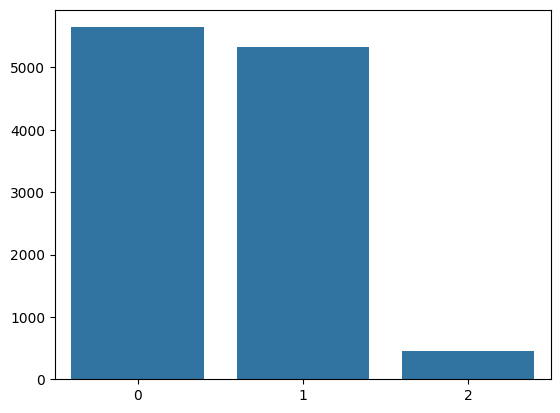

In [7]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['0', '1', '2']), y=dd.values)
plt.show()

In [8]:
print(data_train)

                                                sentence  sentiment
0                              slide giáo_trình đầy_đủ .          2
1         nhiệt_tình giảng_dạy , gần_gũi với sinh_viên .          2
2                   đi học đầy_đủ full điểm chuyên_cần .          0
3      chưa áp_dụng công_nghệ_thông_tin và các thiết_...          0
4      thầy giảng bài hay , có nhiều bài_tập ví_dụ ng...          2
...                                                  ...        ...
11421  chỉ vì môn game mà em học hai lần mà không qua...          0
11422                               em cảm_ơn cô nhiều .          2
11423                           giao bài_tập quá nhiều .          0
11424               giáo_viên dạy dễ hiểu , nhiệt_tình .          2
11425  gói gọn doubledot hay , tận_tình , phù_hợp với...          2

[11426 rows x 2 columns]


In [9]:
def clean_up_text (text):
  text = re.sub(r'[^\w\s]', ' ', text)
  text = re.sub(r'\s+', ' ', text)
  text = re.sub(r'\d', ' ', text)
  return text

In [10]:
print(x_valid)
print(x_train)

0                                giáo_trình chưa cụ_thể .
1                                        giảng buồn_ngủ .
2                          giáo_viên vui_tính , tận_tâm .
3       giảng_viên nên giao bài_tập nhiều hơn , chia n...
4       giảng_viên cần giảng bài chi_tiết hơn , đi_sâu...
                              ...                        
1578                                hướng_dẫn lab mơ_hồ .
1579    thầy cho chúng_em những bài_tập mang tính thực...
1580    thầy không dạy nhiều chủ_yếu cho sinh_viên tự ...
1581    em muốn đổi tên môn_học vì tên môn là lập_trìn...
1582    thầy vừa dạy vừa chat hoặc gọi điện_thoại thườ...
Name: sentence, Length: 1583, dtype: object
0                                slide giáo_trình đầy_đủ .
1           nhiệt_tình giảng_dạy , gần_gũi với sinh_viên .
2                     đi học đầy_đủ full điểm chuyên_cần .
3        chưa áp_dụng công_nghệ_thông_tin và các thiết_...
4        thầy giảng bài hay , có nhiều bài_tập ví_dụ ng...
                       

In [11]:
# Build the vocab and tokenization (padding included)
def tokenize (x_train, x_valid):
  # Build vocab
  word_list = []

  for sentence in x_train:
    for word in sentence.lower().split():
      word = clean_up_text(word)
      if word != ' ':
        word_list.append(word)

  corpus = Counter(set(word_list))
  corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:2000]
  onehot_dict = {w:i+1 for i,w in enumerate(corpus)}

  # Tokenization
  final_list_train, final_list_valid = [], []
  for sentence in x_train:
    final_list_train.append([onehot_dict[clean_up_text(word)] for word in sentence.lower().split() if clean_up_text(word) in onehot_dict.keys()])
  for sentence in x_valid:
    final_list_valid.append([onehot_dict[clean_up_text(word)] for word in sentence.lower().split() if clean_up_text(word) in onehot_dict.keys()])

  # Convert lists to PyTorch tensors
  final_list_train_tensors = [torch.tensor(seq) for seq in final_list_train]
  final_list_valid_tensors = [torch.tensor(seq) for seq in final_list_valid]

# Pad sequences
  final_list_train_padded = pad_sequence(final_list_train_tensors, batch_first=True, padding_value=0)
  final_list_valid_padded = pad_sequence(final_list_valid_tensors, batch_first=True, padding_value=0)
  return np.array(final_list_train_padded), np.array(final_list_valid_padded), onehot_dict

In [12]:
x_train, x_valid, vocab = tokenize(x_train, x_valid)

In [13]:
print(x_valid)
print(x_train)
print(vocab)
print(len(vocab))

[[3079 2805 2348 ...    0    0    0]
 [2960  613    0 ...    0    0    0]
 [3213 2029 1083 ...    0    0    0]
 ...
 [2840 1002 2767 ...    0    0    0]
 [2544 3044 2660 ...    0    0    0]
 [2840 2491 2767 ...    0    0    0]]
[[ 948 3079 2221 ...    0    0    0]
 [1459  769 1523 ...    0    0    0]
 [ 706  146 2221 ...    0    0    0]
 ...
 [2384  426 1276 ...    0    0    0]
 [3213 2767 1411 ...    0    0    0]
 [3068   63 1928 ...    0    0    0]]
{'chung_chung': 1, 'hiễu': 2, 'easy': 3, 'rỏ': 4, 'đời': 5, 'hỏi_đề_hỏi': 6, 'khoa': 7, 'sướng': 8, 'quăng': 9, ' k ': 10, 'té': 11, 'đạt': 12, 'thương_mại_điện_tử': 13, 'unikey': 14, 'sắp': 15, 'pro': 16, 'chém': 17, 'tung': 18, 'lạc_hậu': 19, 'thị_trường': 20, 'poison': 21, 'lạm_dụng': 22, 'rối': 23, 'khoá': 24, 'tuỳ': 25, 'vặt': 26, 'hơn': 27, 'chế_tạo': 28, 'vô_lí': 29, 'độc_đáo': 30, 'hỏi_han': 31, 'phương': 32, 'cô_đọng': 33, 'trở_thành': 34, 'muôn': 35, 'chọn_lọc': 36, 'vấn': 37, 'hành': 38, 'loại_bỏ': 39, 'cám_ơn': 40, 'quy_ước': 

Batching and loading as tensor

In [36]:
# Parameter
batch_size = 64
no_layers = 2
vocab_size = len(vocab) + 1 #extra for padding
embed_dim = 128
output_dim = 3
hidden_dim = 256

In [37]:
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train.values))
valid_data = TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(y_valid.values))

In [38]:
print(train_data[:])

(tensor([[ 948, 3079, 2221,  ...,    0,    0,    0],
        [1459,  769, 1523,  ...,    0,    0,    0],
        [ 706,  146, 2221,  ...,    0,    0,    0],
        ...,
        [2384,  426, 1276,  ...,    0,    0,    0],
        [3213, 2767, 1411,  ...,    0,    0,    0],
        [3068,   63, 1928,  ...,    0,    0,    0]]), tensor([2, 2, 0,  ..., 0, 2, 2]))


In [39]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [40]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print(sample_x.size())
print(sample_x, sample_y)

torch.Size([64, 112])
tensor([[2342, 1017, 2767,  ...,    0,    0,    0],
        [1017,  769, 2239,  ...,    0,    0,    0],
        [2840, 2767, 2239,  ...,    0,    0,    0],
        ...,
        [3299,  946,  630,  ...,    0,    0,    0],
        [3079, 2624,    0,  ...,    0,    0,    0],
        [2840, 2767, 1411,  ...,    0,    0,    0]]) tensor([2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 2,
        2, 2, 1, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2])


Model

In [41]:
class SentimentLSTM(nn.Module):
  def __init__(self, no_layers, vocab_size, hidden_dim, embed_dim, output_dim, drop_prob=0.5):
    super(SentimentLSTM, self).__init__()

    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.no_layers = no_layers
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    # LSTM
    self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=no_layers, batch_first=True, dropout=drop_prob)
    # Dropout layer (is the same as dropout in lstm?)
    self.dropout = nn.Dropout(drop_prob)
    self.fc = nn.Linear(self.hidden_dim, output_dim)
    self.softmax = nn.Softmax(dim=1)
    self.tanh = nn.Tanh() # (???) Use tanh()?


  def forward(self, x, hidden):
    batch_size = x.size(0) #get the number of sentences in a batch, also the first dimension
    embeds = self.embedding(x) #shape: [batch_size, sentence_length, embedding_dim]

    lstm_out, hidden = self.lstm(embeds, hidden) # (???) lstm_out is c<t>? hidden is a<t> (h<t>)?

    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) # (???) Reshape the lstm_out, from [batch_size, sentence_length, hidden_dim] to [batch_size*sentence_length, hidden_dim]

    # dropout and fully connected (???)
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # activation
    tanh_out = self.tanh(out)

    # reshape tanh_out (???) là gì trước khi reshape?
    tanh_out = tanh_out.view(batch_size, -1, self.output_dim)

    softmax_out = self.softmax(tanh_out[:, -1, :])
    return softmax_out, hidden


  def init_hidden_cell(self, batch_size):
    h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
    c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
    hidden = (h0, c0)
    return hidden

In [42]:
model = SentimentLSTM(no_layers, vocab_size, hidden_dim, embed_dim, output_dim, drop_prob=0.5)
model.to(device)
print(model)

SentimentLSTM(
  (embedding): Embedding(3332, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
  (tanh): Tanh()
)


Training

In [55]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [56]:
def acc (pred, label):
  _, pred_label = torch.max(pred, 1)
  correct = (pred_label == label).sum().item()
  acc = (correct / label.size(0))*100
  return acc

In [57]:
# Parameters
clip = 5
epochs = 5
valid_loss_min = np.Inf

In [59]:
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

for epoch in range(epochs):
  train_losses = []
  train_acc = 0.0

  model.train()
  h = model.init_hidden_cell(batch_size)
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    h = tuple([each.data for each in h]) # (???)

    model.zero_grad()
    output, h = model(inputs, h)
    # print (output.shape)
    # print(labels.shape)
    # loss and back prop
    loss = criterion(output, labels) # (???) Kích thước của labels?
    loss.backward()
    train_losses.append(loss.item())

    accuracy = acc (output, labels)
    train_acc += accuracy
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

  val_h = model.init_hidden_cell(batch_size)
  val_losses = []
  val_acc = 0.0
  model.eval()

  for inputs, labels in valid_loader:
    val_h = tuple([each.data for each in val_h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, val_h = model(inputs, val_h)
    val_loss = criterion(output, labels)
    val_losses.append(val_loss.item())
    accuracy = acc(output, labels)
    val_acc += accuracy

  epoch_train_loss = np.mean(train_losses)
  epoch_val_loss = np.mean(val_losses)

  epoch_train_acc = train_acc/len(train_loader.dataset)
  epoch_val_acc = val_acc/len(valid_loader.dataset)

  epoch_tr_loss.append(epoch_train_loss)
  epoch_vl_loss.append(epoch_val_loss)

  epoch_tr_acc.append(epoch_train_acc)
  epoch_vl_acc.append(epoch_val_acc)

  print(f'Epoch {epoch+1}')
  print(f'train loss: {epoch_train_loss}   val_loss: {epoch_val_loss}')
  print(f'train accuracy: {epoch_train_acc}   valid accuracy: {epoch_val_acc}')
  if epoch_val_loss <= valid_loss_min:
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/Sentiment Analysis/Model_LSTM/state_dict.pt')
    print('Valideation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, epoch_val_loss))
    valid_loss_min = epoch_val_loss
  print(15*'==')

Epoch 1
train loss: 0.99721145194568   val_loss: 0.9999457374215126
train accuracy: 0.7410456415193418   valid accuracy: 0.6711939355653822
Valideation loss decreased (inf --> 0.999946). Saving model...
Epoch 2
train loss: 0.9971738159656525   val_loss: 0.9996806482474009
train accuracy: 0.7469258708209348   valid accuracy: 0.7748341756159192
Valideation loss decreased (0.999946 --> 0.999681). Saving model...
Epoch 3
train loss: 0.9972432577208187   val_loss: 0.9999434823791186
train accuracy: 0.7567718361631367   valid accuracy: 0.7689118761844599
Epoch 4
train loss: 0.9972066269831711   val_loss: 1.0002054994304974
train accuracy: 0.7755065202170488   valid accuracy: 0.7738471257106759
Epoch 5
train loss: 0.997245204582643   val_loss: 0.9991532837351164
train accuracy: 0.7596435760546123   valid accuracy: 0.7718730259001895
Valideation loss decreased (0.999681 --> 0.999153). Saving model...
